# Prediction of Dynamic Variables in Sznajd Model

## Imports

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from collections import Counter

CONSENSUS_TIME = 'consensus_time'
OPINION_CHANGE_FREQUENCY = 'opinion_change_frequency'

FEATURES = [
    'clustering', 'closeness', 'betweenness',
    'average_shortest_path_lenght', 'eigenvector', 'assortativity',
    'information_centrality',
    'approximate_current_flow_betweenness_centrality', 'shannon_entropy',
    'degree_variance'
]

UNCORRELATED_FEATURE_SUBSET = [
    'clustering', 
    'closeness',
    'assortativity',
    'shannon_entropy'
]

In [2]:
dataset = pd.read_csv('../data/dataset.csv')
filtered_dataset = dataset[dataset['initialization'] == 'inverse']
# filtered_dataset = dataset.copy()

## Imports

In [3]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, GroupKFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor, TweedieRegressor, LinearRegression
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import optuna

## Metrics

In [4]:
p = 1
from sklearn.metrics import r2_score

def adjusted_r2_score(y: np.array, y_hat: np.array):
    """
    Computes R² score. It decreases if many variables are introduced.
    n: number of observations in sample 
    p: number of independent variables
    """
    n = len(y_hat)
    return 1 - ((1 - r2_score(y, y_hat)) * ((n - 1)/(n - p - 1)))

In [5]:
def make_table(results):
    df = pd.DataFrame()
    df['Coef'] = np.round(res.params, 3)
    df['p-valor'] = np.round(res.pvalues, 3)
    df['Std. error'] = np.round(res.bse, 3)
    return df.to_markdown()

## Linear Regression CV

In [24]:
def LinearRegressionCV(X, y):
    cross_validation = KFold(n_splits=10)

    splits = cross_validation.split(
        X, 
        y=y
    )

    score_list = []
    feature_list = []
    
    regressor = LinearRegression()
    feature_selector = SequentialFeatureSelector(
        regressor,
        # tol=0.01,
        n_features_to_select=2,
        direction='forward'
    )
    
    for train_index, val_index in splits:
        _X_train, _X_val = X.iloc[train_index], X.iloc[val_index]
        _y_train, _y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Feature selection
        sfs = clone(feature_selector) 
        sfs.fit(_X_train, _y_train)
        selected_subset = np.array(FEATURES)[sfs.get_support()]
        p = len(selected_subset)

        # Evaluation
        model = clone(regressor)
        model.fit(_X_train[selected_subset], _y_train)
        y_val_pred = model.predict(_X_val[selected_subset])
        
        score = adjusted_r2_score(np.exp(_y_val), np.exp(y_val_pred))
        score_list.append(score)

        for selected_feature in selected_subset:
            feature_list.append(str(selected_feature))

        # print(f'R2: {score:.3f} w/ {selected_subset}')

    cv_subset = []
    for feature, _ in Counter(feature_list).most_common():
        cv_subset.append(feature)

    print(f'Mean Score: {np.mean(score_list):.3f}')
    
    return cv_subset[:2]

## Consensus Time

In [25]:
X = filtered_dataset[FEATURES]
y = np.log(filtered_dataset[CONSENSUS_TIME])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### Scaler

In [27]:
feature_scaler = StandardScaler()
feature_scaler.fit(X_train[FEATURES])
X_train[FEATURES] = feature_scaler.transform(X_train[FEATURES])
X_test[FEATURES] = feature_scaler.transform(X_test[FEATURES])

### Cross Validation 

In [28]:
SELECTED_SUBSET = LinearRegressionCV(X_train, y_train)
SELECTED_SUBSET

Mean Score: 0.974


['closeness', 'degree_variance']

In [29]:
mod = sm.OLS(
    endog=y_train, 
    exog=sm.add_constant(X_train[SELECTED_SUBSET]),
)
res = mod.fit()
print('Adj. R2', np.round(res.rsquared_adj, 3))
print()
print(make_table(res))

Adj. R2 0.994

|                 |   Coef |   p-valor |   Std. error |
|:----------------|-------:|----------:|-------------:|
| const           |  6.626 |         0 |        0.006 |
| closeness       | -1.71  |         0 |        0.009 |
| degree_variance |  0.237 |         0 |        0.009 |


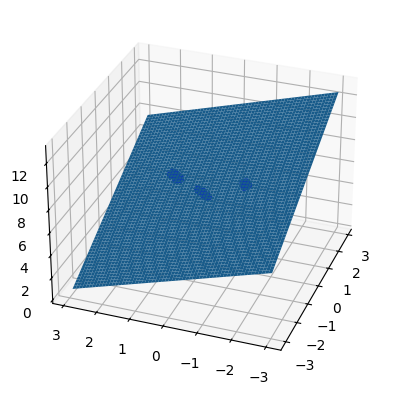

In [178]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_surf = np.arange(-3, 3, 0.1)                # generate a mesh
y_surf = np.arange(-3, 3, 0.1)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)
exog = sm.add_constant(pd.DataFrame([x_surf.ravel(), y_surf.ravel()]).T)
out = res.predict(exog = exog)
ax.plot_surface(
    x_surf, 
    y_surf, 
    np.array(out).reshape(x_surf.shape),
    rstride=1,
    cstride=1
)
ax.scatter(
    X_test['closeness'], X_test['closeness'], y_test,
    c='blue',
    marker='o',
    alpha=1
)
ax.view_init(30, 200) 
plt.show()


### Testing

In [114]:
y_pred = res.predict(sm.add_constant(X_test[SELECTED_SUBSET]))
p = 2
print('Test Adj. R2', adjusted_r2_score(y_pred, y_test))

Test Adj. R2 0.9976926693662183


## Opinion Change Frequency

In [14]:
filtered_dataset = dataset[dataset['initialization'] == 'random']
X = filtered_dataset[UNCORRELATED_FEATURE_SUBSET]
y = np.log(filtered_dataset[OPINION_CHANGE_FREQUENCY])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### Scaler

In [16]:
feature_scaler = StandardScaler()
feature_scaler.fit(X_train[UNCORRELATED_FEATURE_SUBSET])
X_train[UNCORRELATED_FEATURE_SUBSET] = feature_scaler.transform(X_train[UNCORRELATED_FEATURE_SUBSET])
X_test[UNCORRELATED_FEATURE_SUBSET] = feature_scaler.transform(X_test[UNCORRELATED_FEATURE_SUBSET])

### Cross Validation 

In [17]:
SELECTED_SUBSET = LinearRegressionCV(X_train, y_train)
SELECTED_SUBSET

Mean Score: 0.945


['clustering', 'closeness']

In [18]:
mod = sm.OLS(
    endog=y_train, 
    exog=sm.add_constant(X_train[SELECTED_SUBSET]),
)
res = mod.fit()
# res.summary(slim=True)
print('Adj. R2', np.round(res.rsquared_adj, 3))
print()
print(make_table(res))

Adj. R2 0.988

|            |   Coef |   p-valor |   Std. error |
|:-----------|-------:|----------:|-------------:|
| const      |  5.937 |         0 |        0.004 |
| clustering |  0.73  |         0 |        0.009 |
| closeness  | -0.111 |         0 |        0.009 |


### Testing

In [35]:
y_pred = res.predict(sm.add_constant(X_test[SELECTED_SUBSET]))
p = 2
adjusted_r2_score(y_pred, y_test)

0.993715248655325

Text(0.5, 1.0, 'Consensus Time')

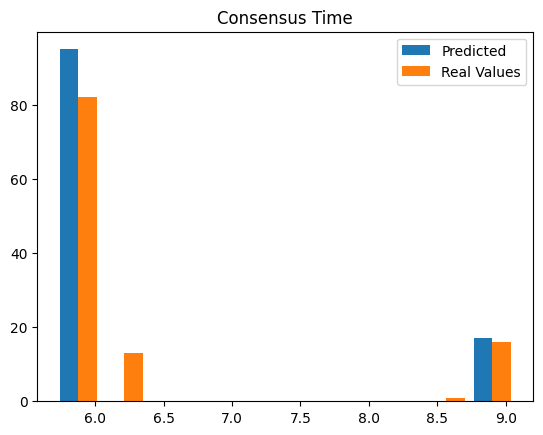

In [36]:
plt.hist([y_pred, y_test])
plt.legend(['Predicted', 'Real Values'])
plt.title('Consensus Time')